# Rodrigo Mendoza Rodriguez Examen

In [2]:
import zipfile
from pathlib import Path

base = Path.cwd().parent
path_zip = base / 'author_profiling_pan.zip'
with zipfile.ZipFile(path_zip, "r") as z:
    z.extractall("carpeta_docs")

In [3]:
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

stop_words = set(stopwords.words("spanish"))
tokenizer = TweetTokenizer()


def limpiar_texto(texto):
    texto = BeautifulSoup(texto, "html.parser").get_text()
    texto = texto.lower()
    texto = re.sub(r"http\S+|www\S+|https\S+", "", texto)
    texto = re.sub(r"@\w+", "", texto)
    texto = re.sub(r"#+", "", texto)
    return texto


In [4]:
import os
import xml.etree.ElementTree as ET
def get_texts_from_folder(path_folder):
    tr_txt = []  # aquí van los documentos
    tr_y = []    # aquí van las etiquetas

    for file in os.listdir(path_folder):
        if file.endswith(".xml"):
            tree = ET.parse(os.path.join(path_folder, file))
            root = tree.getroot()
            docs = []
            for doc in root.iter("document"):
                texto_limpio = limpiar_texto(doc.text)
                if texto_limpio:  #
                    docs.append(texto_limpio)
            if docs:
                tr_txt.append(" ".join(docs))

    truth_file = os.path.join(path_folder, "truth.txt")
    if os.path.exists(truth_file):
        file_to_label = {}
        with open(truth_file, "r", encoding="utf-8") as f:
            for line in f:
                parts = line.strip().split(":::")
                if len(parts) >= 3:
                    file_to_label[parts[0]] = parts[1]

        for file in os.listdir(path_folder):
            if file.endswith(".xml"):
                file_id = file.split('.')[0]
                if file_id in file_to_label:
                    tr_y.append(file_to_label[file_id])

    return tr_txt, tr_y

In [5]:

path_test = 'carpeta_docs/author_profiling_pan/es_test/'
path_train = 'carpeta_docs/author_profiling_pan/es_train/'
tr_txt_train, tr_y_train = get_texts_from_folder(path_train)
tr_txt_test, tr_y_test = get_texts_from_folder(path_test)

print(f"\nTextos train: {len(tr_txt_train)}, Etiquetas train: {len(tr_y_train)}")

genero = sorted(list(set(tr_y_train)))
genero_numerico = {genero: idx for idx, genero in enumerate(genero)}

y_train = [genero_numerico[genero] for genero in tr_y_train]
y_test  = [genero_numerico[genero] for genero in tr_y_test]



C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_8292\3663305902.py:11: MarkupResemblesLocatorWarning: The input passed in on this line looks more like a URL than HTML or XML.

If you meant to use Beautiful Soup to parse the web page found at a certain URL, then something has gone wrong. You should use an Python package like 'requests' to fetch the content behind the URL. Once you have the content as a string, you can feed that string into Beautiful Soup.

However, if you want to parse some data that happens to look like a URL, then nothing has gone wrong: you are using Beautiful Soup correctly, and this warning is spurious and can be filtered. To make this warning go away, run this code before calling the BeautifulSoup constructor:

    from bs4 import MarkupResemblesLocatorWarning
    import warnings

    warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
    
  texto = BeautifulSoup(texto, "html.parser").get_text()



Textos train: 4200, Etiquetas train: 4200


In [6]:
import nltk
corpus_de_palabras = []
for doc in tr_txt_train:
    if doc and isinstance(doc, str):
        corpus_de_palabras += tokenizer.tokenize(doc)
corpus_de_palabras = [token for token in corpus_de_palabras if re.match(r"^[a-zA-ZáéíóúÁÉÍÓÚñÑ]+$", token)]

fdist = nltk.FreqDist(corpus_de_palabras)
V = [word for word, _ in fdist.most_common(10000)]
dict_indices = {word: i for i, word in enumerate(V)}

In [7]:
import numpy as np
def built_bow_tr_binario(tr_txt, vocabulario, dict_indices):
    bow = np.zeros((len(tr_txt), len(vocabulario)), dtype=np.int8)
    for cont_doc, tr in enumerate(tr_txt):
        if not tr or not isinstance(tr, str):
            continue
        tokens = tokenizer.tokenize(tr.lower())
        for word in tokens:
            if word in dict_indices:
                bow[cont_doc, dict_indices[word]] = 1
    return bow

In [8]:
bow_tr = built_bow_tr_binario(tr_txt_train, V, dict_indices)
bow_tr

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], shape=(4200, 10000), dtype=int8)

In [9]:
bow_test  = built_bow_tr_binario(tr_txt_test, V, dict_indices)

# Parte 1

1.1 Construye una Bolsa de Palabras Binaria, normalízala con L2 y evalúa con SVM.

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import normalize
from sklearn import svm, metrics
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix


bow_train_L2 = normalize(bow_tr, norm='l2')
bow_test_L2  = normalize(bow_test, norm='l2')

parametros = {'C': [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10]}
svr = svm.LinearSVC(class_weight='balanced', max_iter=10000)

grid = GridSearchCV(estimator=svr, param_grid=parametros, n_jobs=4, scoring='f1_macro', cv=5)
grid.fit(bow_train_L2, y_train)

y_pred = grid.predict(bow_test_L2)

prec_bin, rec_bin, f1_bin, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')

print("\nMatriz de confusión:\n", confusion_matrix(y_test, y_pred))
print("\nReporte de clasificación:\n", metrics.classification_report(y_test, y_pred))



Matriz de confusión:
 [[1117  283]
 [ 293 1107]]

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      0.80      0.80      1400
           1       0.80      0.79      0.79      1400

    accuracy                           0.79      2800
   macro avg       0.79      0.79      0.79      2800
weighted avg       0.79      0.79      0.79      2800



1.2 Construye una Bolsa de Palabras con pesado TF-IDF, normalízala con L2 y
evalúa con SVM.

In [11]:
def built_bow_tfidf(tr_txt, vocabulario, dict_indices):
    bow = np.zeros((len(tr_txt), len(vocabulario)), dtype=np.float32)
    
    for cont_doc, tr in enumerate(tr_txt):
        if not tr or not isinstance(tr, str):
            continue
        tokens = tokenizer.tokenize(tr.lower())
        for word in tokens:
            if word in dict_indices:
                bow[cont_doc, dict_indices[word]] += 1

    df = np.count_nonzero(bow > 0, axis=0)

    for j in range(len(vocabulario)):
        if df[j] > 0:
            bow[:, j] = bow[:, j] / df[j]
    
    return bow

In [12]:
bow_tr_idf = built_bow_tfidf(tr_txt_train, V, dict_indices)
bow_tr_idf

array([[0.01288783, 0.0055355 , 0.00478126, ..., 0.        , 0.        ,
        0.        ],
       [0.0071599 , 0.01083033, 0.00454219, ..., 0.        , 0.        ,
        0.        ],
       [0.01670644, 0.00409146, 0.01625627, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.01527446, 0.00264741, 0.00597657, ..., 0.        , 0.        ,
        0.        ],
       [0.01980907, 0.00481348, 0.0083672 , ..., 0.        , 0.        ,
        0.        ],
       [0.01264916, 0.01492178, 0.01195314, ..., 0.        , 0.        ,
        0.        ]], shape=(4200, 10000), dtype=float32)

In [13]:
bow_test_idf = built_bow_tfidf(tr_txt_test, V, dict_indices)
bow_test_idf

array([[0.01574803, 0.00036258, 0.01433692, ..., 0.        , 0.        ,
        0.        ],
       [0.01896922, 0.00471356, 0.03225806, ..., 0.        , 0.        ,
        0.        ],
       [0.03972799, 0.02538071, 0.01863799, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.01932713, 0.00108774, 0.00573477, ..., 0.        , 0.        ,
        0.        ],
       [0.01717967, 0.02719362, 0.0125448 , ..., 0.        , 0.        ,
        0.        ],
       [0.01717967, 0.01921682, 0.00967742, ..., 0.        , 0.        ,
        0.        ]], shape=(2800, 10000), dtype=float32)

In [14]:
bow_train_idf_L2 = normalize(bow_tr_idf, norm='l2')
bow_test_idf_L2  = normalize(bow_test_idf, norm='l2')

parametros = {'C': [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10]}
svr = svm.LinearSVC(class_weight='balanced', max_iter=10000)

grid = GridSearchCV(estimator=svr, param_grid=parametros, n_jobs=4, scoring='f1_macro', cv=5)
grid.fit(bow_train_idf_L2, y_train)

y_pred = grid.predict(bow_test_idf_L2)

prec_idf, rec_idf, f1_idf, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')

print("\nMatriz de confusión:\n", confusion_matrix(y_test, y_pred))
print("\nReporte de clasificación:\n", metrics.classification_report(y_test, y_pred))


Matriz de confusión:
 [[1016  384]
 [ 353 1047]]

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.74      0.73      0.73      1400
           1       0.73      0.75      0.74      1400

    accuracy                           0.74      2800
   macro avg       0.74      0.74      0.74      2800
weighted avg       0.74      0.74      0.74      2800



In [16]:
import pandas as pd

resultados = pd.DataFrame({
    "Modelo": ["BoW Binario", "BoW TF-IDF"],
    "Precisión": [prec_bin, prec_idf],
    "Recall": [rec_bin, rec_idf],
    "F1 Score": [f1_bin, f1_idf]
})

print(resultados)

        Modelo  Precisión    Recall  F1 Score
0  BoW Binario   0.794301  0.794286  0.794283
1   BoW TF-IDF   0.736902  0.736786  0.736753


# Parte 2

2.1 Grafica la constelación de las 1000 mejores palabras según DOR del dataset.

In [17]:
import numpy as np
def built_bow_tr_frecuencia(tr_txt, vocabulario, dict_indices):
    bow = np.zeros((len(tr_txt), len(vocabulario)), dtype=int)
    for cont_doc, tr in enumerate(tr_txt):
        if not tr or not isinstance(tr, str):
            continue
        tokens = tokenizer.tokenize(tr.lower())
        fdist_doc = nltk.FreqDist(tokens)
        for word in fdist_doc:
            if word in dict_indices:
                bow[cont_doc, dict_indices[word]] = fdist_doc[word]
    return bow

In [18]:
tokenizer = TweetTokenizer()
corpus_de_palabras_f = []
for doc in tr_txt_train:
    if isinstance(doc, str):
        corpus_de_palabras_f += tokenizer.tokenize(doc)

fdist = nltk.FreqDist(corpus_de_palabras_f)

V_f = [word for word, _ in fdist.most_common(10000)]
dict_indices_f = {word: i for i, word in enumerate(V_f)}


In [19]:
bow_train_frecuencia = built_bow_tr_frecuencia(tr_txt_train,V_f,dict_indices_f)
print(bow_train_frecuencia)
bow_train_frecuencia.shape

[[ 54  34  14 ...   0   0   0]
 [ 30  21   3 ...   0   0   0]
 [ 70  48  73 ...   0   0   0]
 ...
 [ 64  11   0 ...   0   0   0]
 [ 83  67  25 ...   0   0   0]
 [ 53  52 107 ...   0   0   0]]


(4200, 10000)

In [20]:
def compute_dor(TR):
  shapes=TR.shape
  DTR=np.zeros((shapes[1], shapes[0]), dtype=np.float64)
  tam_V=TR.shape[1]

  for doc, i in zip(TR, range(len(TR))): #Iterar por cada documento
    non_zero_positions=np.nonzero(doc)[0] #Numeros de las dimensiones de las palabras contenidas en el tweet
    tam_v=len(non_zero_positions)
    for term in non_zero_positions:
      DTR[term, i] = np.log10(1+doc[term])*np.log10(tam_V/tam_v)
  return DTR

In [21]:
DOR_base = compute_dor(bow_train_frecuencia)
DOR_base.shape

(10000, 4200)

In [22]:
DOR_normalizado = normalize(DOR_base, norm='l2')

In [23]:
from sklearn.feature_selection import SelectKBest, chi2

feats = SelectKBest(chi2, k=1000)

feats.fit(bow_train_frecuencia, y_train)

,"score_func score_func: callable, default=f_classifFunction taking two arrays X and y, and returning a pair of arrays(scores, pvalues) or a single array with scores.Default is f_classif (see below ""See Also""). The default function onlyworks with classification tasks... versionadded:: 0.18",<function chi...00282D3B3D580>
,"k k: int or ""all"", default=10Number of top features to select.The ""all"" option bypasses selection, for use in a parameter search.",1000


In [24]:
best = feats.get_support(indices=True)
best

array([   0,    1,    2,    4,    5,    6,    7,    8,    9,   11,   12,
         13,   14,   15,   16,   17,   18,   19,   21,   22,   23,   25,
         26,   27,   28,   29,   31,   35,   37,   38,   39,   40,   41,
         42,   43,   44,   45,   46,   47,   48,   51,   52,   53,   55,
         56,   61,   62,   67,   71,   72,   73,   74,   75,   77,   80,
         82,   85,   86,   87,   88,   91,   95,  100,  102,  103,  106,
        111,  112,  113,  114,  115,  118,  119,  121,  122,  127,  128,
        129,  130,  134,  138,  141,  143,  145,  149,  150,  152,  154,
        158,  161,  162,  166,  169,  170,  171,  173,  179,  180,  181,
        183,  184,  186,  188,  189,  190,  193,  197,  200,  204,  205,
        208,  211,  213,  220,  222,  223,  224,  229,  230,  231,  233,
        234,  235,  238,  241,  243,  244,  247,  250,  251,  253,  254,
        255,  257,  260,  262,  264,  267,  271,  272,  274,  285,  286,
        287,  289,  294,  295,  306,  310,  313,  3

In [25]:
dict_indices_alreves = {}
for palabra, indice in dict_indices.items():
    dict_indices_alreves[indice] = palabra
target_word = [dict_indices_alreves[index] for index in best]
t_words = target_word
t_words

['de',
 'que',
 'la',
 'el',
 'a',
 'en',
 'no',
 'es',
 'los',
 'un',
 'por',
 'se',
 'con',
 'lo',
 'para',
 'del',
 'las',
 'una',
 'mi',
 'si',
 'al',
 'más',
 'pero',
 'ya',
 'q',
 'su',
 'todo',
 'cuando',
 'este',
 'hay',
 'o',
 'vía',
 'hoy',
 'qué',
 'son',
 'eso',
 'muy',
 'ser',
 'está',
 'día',
 'nos',
 'sin',
 'bien',
 'siempre',
 'quiero',
 'ahora',
 'solo',
 'hace',
 'tan',
 'hacer',
 'esto',
 'fue',
 'año',
 'hasta',
 'gente',
 'ese',
 'días',
 'esa',
 'les',
 'mis',
 'd',
 'voy',
 'jajaja',
 'también',
 'mañana',
 'cosas',
 'nuevo',
 'menos',
 'dos',
 'vamos',
 'tiempo',
 'cada',
 'estar',
 'donde',
 'están',
 'país',
 'mismo',
 'x',
 'cómo',
 'eres',
 'ir',
 'tanto',
 'igual',
 'buenos',
 'sí',
 'gobierno',
 'semana',
 'jajajaja',
 'entre',
 'favor',
 'personas',
 'debe',
 'toda',
 'estamos',
 'parece',
 'fin',
 'todas',
 'trabajo',
 'decir',
 'sólo',
 'falta',
 'méxico',
 'tú',
 'grande',
 'quiere',
 'nuevos',
 'ganas',
 'gusta',
 'equipo',
 'final',
 'poder',
 'colo

In [26]:
# dict_indices {palabra : dimension_en_bow}
target_matrix = np.array([DOR_normalizado[dict_indices[word]] for word in t_words])
target_matrix.shape

(1000, 4200)

In [27]:
from sklearn.manifold import TSNE
 
 
reduce_matrix = TSNE(n_components=2).fit_transform(target_matrix)
reduce_matrix

array([[  0.16981195,   1.7942747 ],
       [ -0.5405219 ,   1.0490439 ],
       [  0.598309  ,   2.8757088 ],
       ...,
       [ -2.3611035 , -33.381824  ],
       [ -0.37795454,  30.149029  ],
       [-16.261234  , -22.164906  ]], shape=(1000, 2), dtype=float32)

In [28]:
max_x , max_y = np.max(reduce_matrix, axis=0)
min_x , min_y = np.min(reduce_matrix, axis=0)


print(f"max_x: {max_x}, max_y: {max_y}")
print(f"min_x: {min_x}, min_y: {min_y}")

max_x: 35.4703254699707, max_y: 37.92539978027344
min_x: -36.754600524902344, min_y: -36.014400482177734


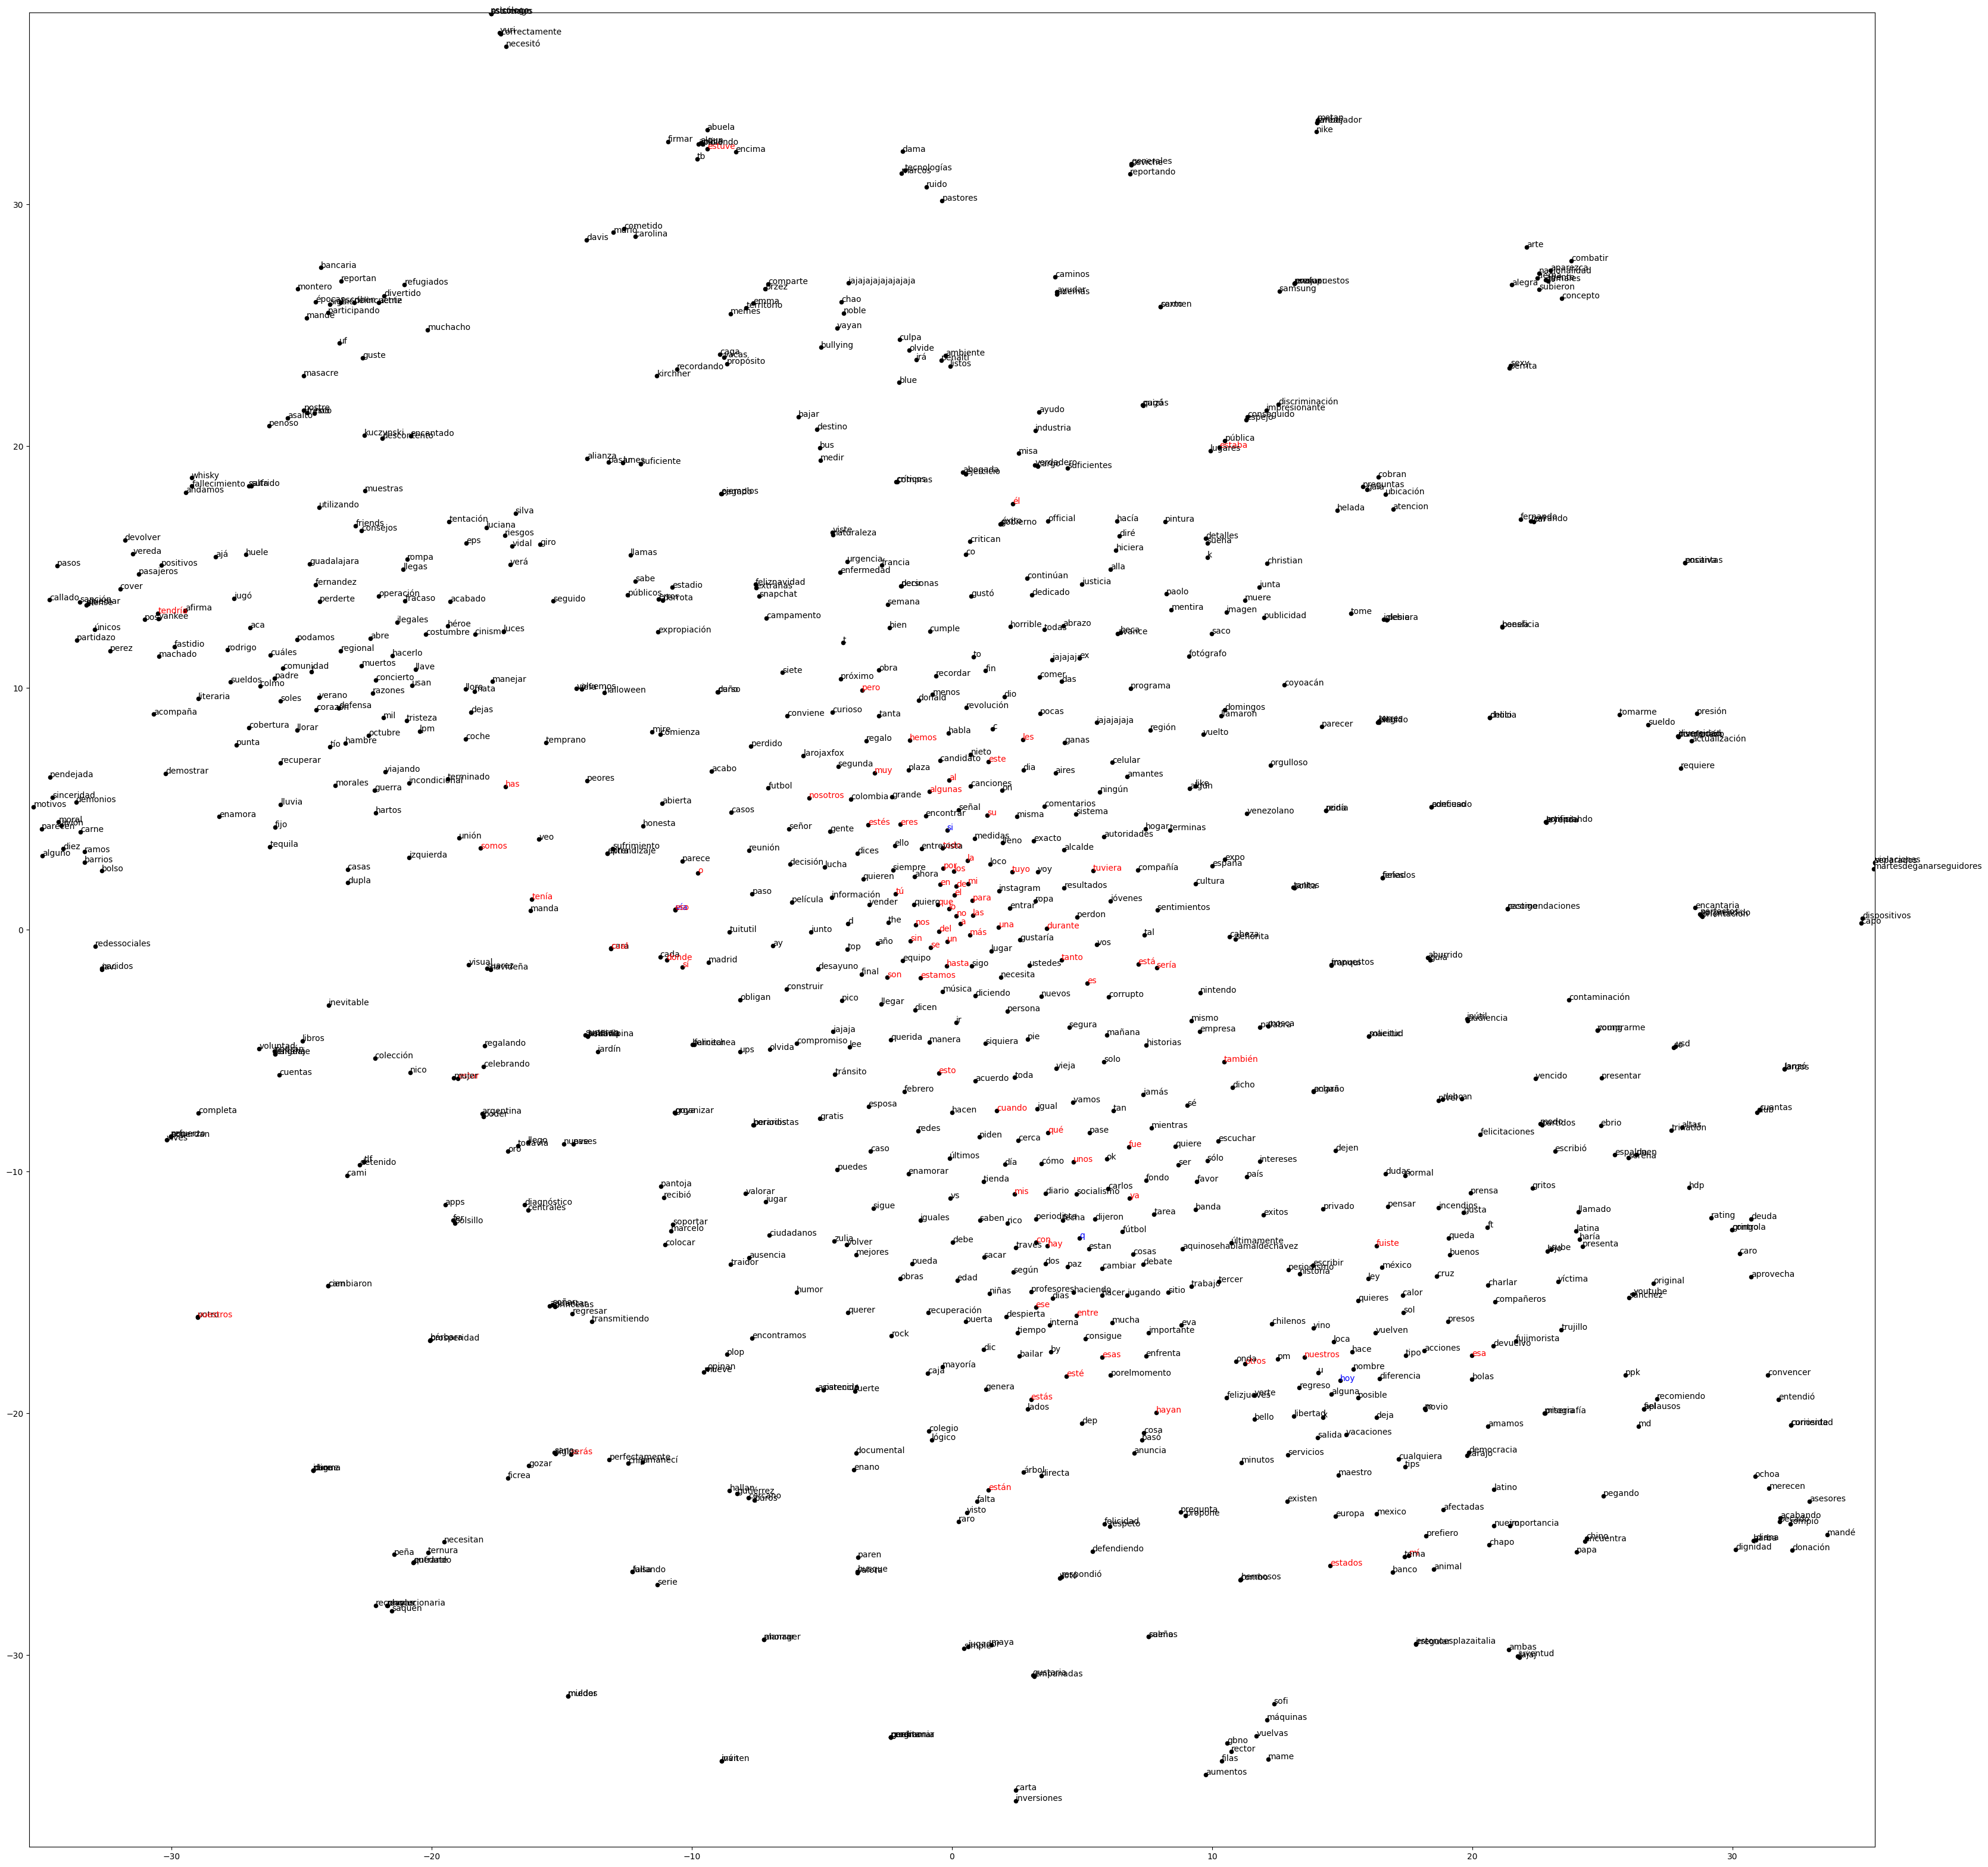

In [29]:
import matplotlib.pyplot as plt
max_x = np.amax(reduce_matrix, axis=0)[0]
max_y = np.amax(reduce_matrix, axis=0)[1]
plt.figure(figsize=(40,40), dpi=100)
plt.xlim((-max_x, max_x))
plt.ylim((-max_y, max_y))

plt.scatter(reduce_matrix[:, 0], reduce_matrix[:, 1], 20, color='black')

from nltk.corpus import stopwords
sw = set(stopwords.words('spanish'))

# Agregar una lista de 20 palabras que eliga y poner de otro color (azul)
highlight_words = t_words[15:35]

for idx, word in enumerate(t_words[:]):
    x = reduce_matrix[idx, 0]
    y = reduce_matrix[idx, 1]

    if word in sw:  
        plt.annotate(word, (x, y), color='red')
    elif word in highlight_words:  
        plt.annotate(word, (x, y), color='blue')
    else:  
        plt.annotate(word, (x, y), color='black')
    

In [30]:
from wordcloud import WordCloud

In [31]:
chi2_scores = feats.scores_ 
best_scores = chi2_scores[best]

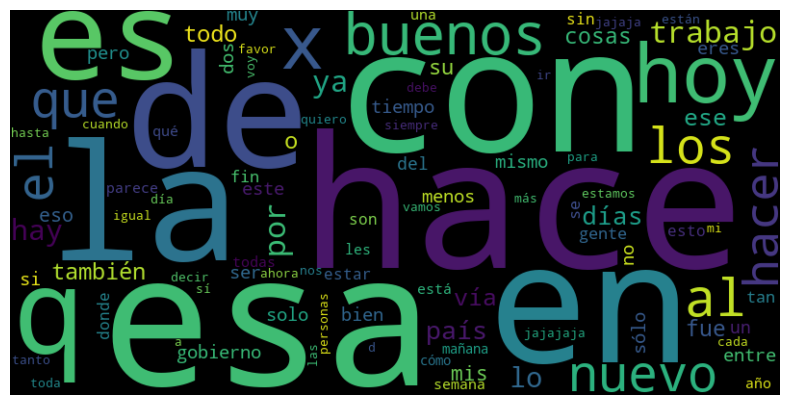

In [32]:
# Chi2
best_dict = {}
for palabra, indice in dict_indices.items():
    if indice in best[:100]:   
        best_dict[palabra] = chi2_scores[indice]  
top100 = dict(sorted(best_dict.items(), key=lambda x: x[1], reverse=True)[:100])

# Generar y mostrar la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(top100)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


# Parte 3

3.1 Programa TCOR (term co-occurrence matrix) como se propone en el paper de
Lavelli indicado en este examen

In [33]:
import numpy as np
from scipy.sparse import csr_matrix, diags

def build_tcor(texts, vocabulario, dict_indices, tokenizer, context="document"):
    """
    Construye la matriz TCOR (Term Co-occurrence Representation) optimizada con scipy.sparse.

    Args:
        texts: lista de strings (documentos o ejemplos de entrenamiento)
        vocabulario: lista de términos (V)
        dict_indices: diccionario {termino: indice}
        tokenizer: función/objeto que tokeniza los textos
        context: "document" (default) usa documento completo como contexto,
                 "sentence" divide por '.' y usa cada oración como contexto

    Returns:
        tcor: matriz |V| x |V| (scipy.sparse csr_matrix), 
              cada columna es el vector de un término normalizado con L2
    """
    n_terms = len(vocabulario)

    context_sets = []
    for txt in texts:
        if not isinstance(txt, str) or not txt:
            continue
        if context == "sentence":
            unidades = [s for s in txt.split('.') if s.strip()]
        else:
            unidades = [txt]

        for u in unidades:
            idxs = set()
            for w in tokenizer.tokenize(u.lower()):
                if w in dict_indices:
                    idxs.add(dict_indices[w])
            if idxs:
                context_sets.append(sorted(idxs))

    rows, cols = [], []
    for r, idxs in enumerate(context_sets):
        rows.extend([r]*len(idxs))
        cols.extend(idxs)

    data = np.ones(len(rows), dtype=np.float32)
    A = csr_matrix((data, (rows, cols)), shape=(len(context_sets), n_terms), dtype=np.float32)

    C = (A.T @ A).tocsr()

    C = C.tocoo()
    data_tff = 1.0 + np.log(C.data)
    TF = csr_matrix((data_tff, (C.row, C.col)), shape=C.shape)

    df_terms = np.diff(C.tocsr().indptr)
    idf = np.zeros(n_terms, dtype=np.float32)
    mask = df_terms > 0
    idf[mask] = np.log(n_terms / df_terms[mask])

    TFIDF = diags(idf, format="csr") @ TF

    col_norms = np.sqrt(TFIDF.power(2).sum(axis=0)).A1
    col_norms[col_norms == 0.0] = 1.0
    inv_norms = diags(1.0 / col_norms, format="csr")
    TCOR = TFIDF @ inv_norms

    return TCOR


# Creamos el TCOR con vocabulario de 5000 para que no tarde tanto corriendo

In [34]:
corpus_de_palabras = []
for doc in tr_txt_train:
    if doc and isinstance(doc, str):
        corpus_de_palabras += tokenizer.tokenize(doc)
corpus_de_palabras = [token for token in corpus_de_palabras if re.match(r"^[a-zA-ZáéíóúÁÉÍÓÚñÑ]+$", token)]

fdist = nltk.FreqDist(corpus_de_palabras)
V = [word for word, _ in fdist.most_common(5000)]
dict_indices = {word: i for i, word in enumerate(V)}

In [35]:
tcor_matrix = build_tcor(tr_txt_train, V, dict_indices, tokenizer, context="document")

 Proyéctalo con t-SNE a dos dimensiones y muestra la constelación de las 1000
mejores palabras en TCOR.

In [36]:
valid_words = [w for w in t_words if w in dict_indices]
tcor_dense = tcor_matrix.toarray() if not isinstance(tcor_matrix, np.ndarray) else tcor_matrix

target_matrix = np.array([tcor_dense[:, dict_indices[w]] for w in valid_words])

reduce_matrix = TSNE(n_components=2, random_state=42).fit_transform(target_matrix)

In [37]:
max_x , max_y = np.max(reduce_matrix, axis=0)
min_x , min_y = np.min(reduce_matrix, axis=0)


print(f"max_x: {max_x}, max_y: {max_y}")
print(f"min_x: {min_x}, min_y: {min_y}")

max_x: 14.574971199035645, max_y: 14.305131912231445
min_x: -17.541091918945312, min_y: -13.216139793395996


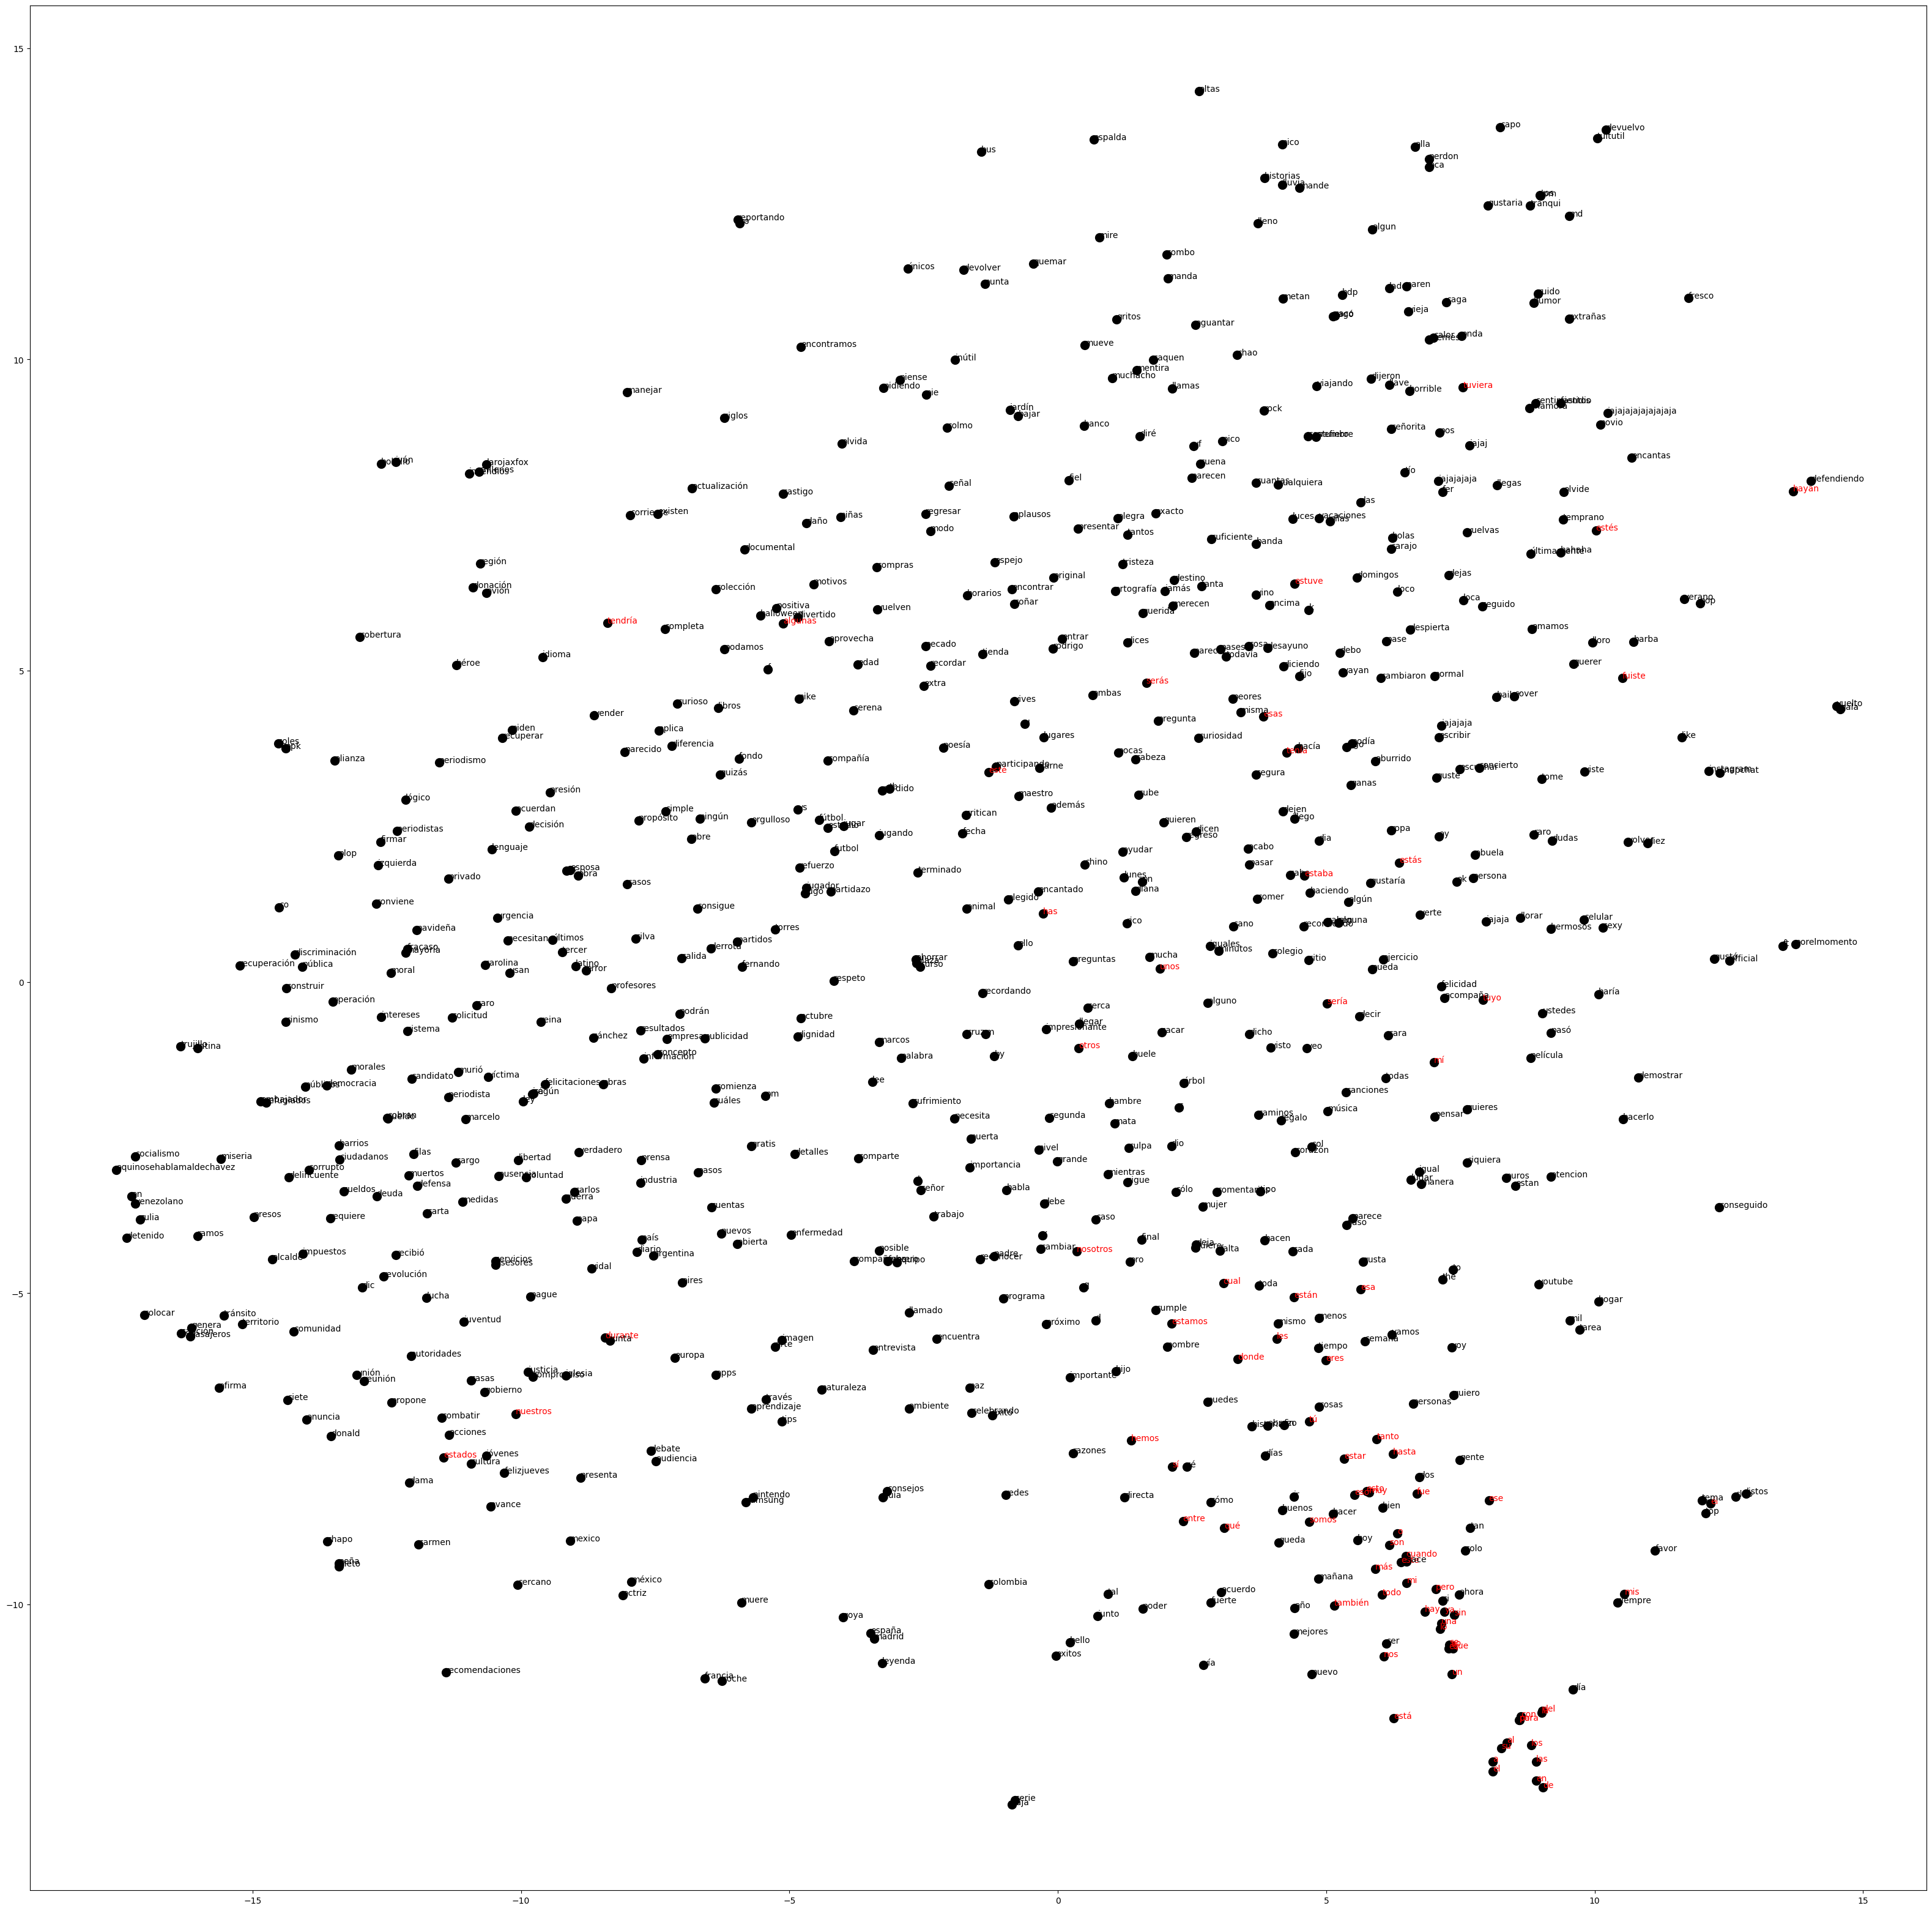

In [38]:
plt.figure(figsize=(40,40), dpi=100)
plt.scatter(reduce_matrix[:, 0], reduce_matrix[:, 1], 100, color='black')

for idx, word in enumerate(valid_words):
    x = reduce_matrix[idx, 0]
    y = reduce_matrix[idx, 1]

    if word in sw:  
        plt.annotate(word, (x, y), color='red')
    else:  
        plt.annotate(word, (x, y), color='black')
